In [7]:
### Solution
import numpy as np
import pandas as pd
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.compose import ColumnTransformer
import openml
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Przygotowanie modeli danych
- Pobranie zbioru danych

In [8]:
dataset_names = ["cholesterol", "liver-disorders", "bodyfat", "plasma_retinol"]
datasets = openml.datasets.get_datasets(dataset_names)


- Podzielenie zbioru danych

In [9]:
#split datasets into train and test
train_datasets = {}
test_datasets = {}
for dataset in datasets:
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    train_datasets[dataset.name] = (X_train, y_train)
    test_datasets[dataset.name] = (X_test, y_test)


- Transformacje:
    uzupełnienie brakujących danych, zakodowanie otrzymanych zbiorów

In [10]:
### operations for numerical columns
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('scale', MinMaxScaler())
])

### operations for categorical columns
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline, make_column_selector(dtype_exclude= np.number))
    ],
    remainder='drop',
    n_jobs=-1)

train_datasets_transformed = {}
test_datasets_transformed = {}
for name in train_datasets.keys():
    fit_trans_X = col_trans.fit(train_datasets[name][0])
    train_datasets_transformed[name] = fit_trans_X.transform(train_datasets[name][0])
    test_datasets_transformed[name] = fit_trans_X.transform(test_datasets[name][0])

    fit_trans_y = col_trans.fit(pd.DataFrame(train_datasets[name][1].values))
    train_datasets_transformed[name] = (train_datasets_transformed[name], fit_trans_y.transform(pd.DataFrame(train_datasets[name][1].values)))
    test_datasets_transformed[name] = (test_datasets_transformed[name], fit_trans_y.transform(pd.DataFrame(test_datasets[name][1].values)))


/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Przygotowanie uczenia maszynowego

In [11]:
import aml_helper
from estimator_types import EstimatorType
import estimator_types as et
estimator_types = [EstimatorType.ELASTIC_NET, EstimatorType.SVR, EstimatorType.SGD]


Wylosowanie losowych zbiorów parametrów, które będą użyte jako bazowa wartość predykcji

In [154]:
def get_best_params(result_dict):
    averages_per_estimator = {}
    for est_type, res in result_dict.items():
        averages = []
        for i in range(len(next(iter(res.values()))[0])):
            averages.append((
                next(iter(res.values()))[0][i],
                sum(res[set_name][1][i] for set_name in dataset_names) / len(dataset_names),
                i
            ))
        averages.sort(key=lambda pair: pair[1], reverse=True)
        averages_per_estimator[est_type] = averages
        
    return {est_type: values[0] for est_type, values in averages_per_estimator.items()}


In [155]:
### Random search

random_search_tries = 5
random_search_results = {}
for estimator_type in estimator_types:
    for name in train_datasets_transformed.keys():
        estimator = et.get_estimator(estimator_type)
        params = et.get_parameters(estimator_type)
        data_X, data_y = train_datasets_transformed[name]
        
        result = aml_helper.perform_random_search(estimator, params, data_X, data_y, n_iter=random_search_tries, random_state=42)
        
        if estimator_type not in random_search_results.keys():
            random_search_results[estimator_type] = {}
        random_search_results[estimator_type][name] = result
        
random_search_best = get_best_params(random_search_results)
random_search_best


/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e-01, tolerance: 4.753e-04
  model = cd_fast.enet_coordinate_descent(
/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.544e-02, tolerance: 5.026e-04
  model = cd_fast.enet_coordinate_descent(
/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

{'ElasticNet': ({'l1_ratio': 0.1, 'alpha': 0.0001}, -0.10298042734924098, 2),
 'SVR': ({'kernel': 'linear', 'gamma': 'scale', 'C': 10},
  -0.11022775757887222,
  4),
 'SGD': ({'penalty': 'l1',
   'loss': 'epsilon_insensitive',
   'learning_rate': 'adaptive',
   'alpha': 0.05},
  -0.11410081162552248,
  3)}

Tunowanie jednostajne

In [105]:
### Grid search

grid_search_results = {}
for estimator_type in estimator_types:
    for name in train_datasets_transformed.keys():
        estimator = et.get_estimator(estimator_type)
        params = et.get_parameters(estimator_type)
        data_X, data_y = train_datasets_transformed[name]
        
        result = aml_helper.perform_grid_search(estimator, params, data_X, data_y)
        
        if estimator_type not in grid_search_results.keys():
            grid_search_results[estimator_type] = {}
        grid_search_results[estimator_type][name] = result
        
grid_search_best = get_best_params(grid_search_results)
grid_search_best


/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e-01, tolerance: 4.753e-04
  model = cd_fast.enet_coordinate_descent(
/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.544e-02, tolerance: 5.026e-04
  model = cd_fast.enet_coordinate_descent(
/home/uxeruses/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

{'ElasticNet': ({'alpha': 0.0001, 'l1_ratio': 0.9}, -0.10231580757077052),
 'SVR': ({'C': 1, 'gamma': 'scale', 'kernel': 'linear'}, -0.1090513510763351),
 'SGD': ({'alpha': 0.0001,
   'learning_rate': 'adaptive',
   'loss': 'epsilon_insensitive',
   'penalty': 'l2'},
  -0.10747159314018896)}

Tunowanie Bayesowskie

In [15]:
### Bayes search

bayes_search_results = {}
for estimator_type in estimator_types:
    for name in train_datasets_transformed.keys():
        estimator = et.get_estimator(estimator_type)
        params = et.get_bayes_parameters(estimator_type)
        data_X, data_y = train_datasets_transformed[name]
        
        result = aml_helper.perform_bayes_search(estimator, params, data_X, data_y, n_iter=50, random_state=42)
        
        if estimator_type not in bayes_search_results.keys():
            bayes_search_results[estimator_type] = {}
        bayes_search_results[estimator_type][name] = result
        
bayes_search_best = get_best_params(bayes_search_results)
bayes_search_best


/home/uxeruses/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/uxeruses/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/uxeruses/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/uxeruses/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/uxeruses/.local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The object

{'ElasticNet': (OrderedDict([('alpha', 0.4445650705619027),
               ('l1_ratio', 0.6259666190623304)]),
  -0.09872887018368318),
 'SVR': (OrderedDict([('C', 654), ('gamma', 'scale'), ('kernel', 'linear')]),
  -0.10767642797096941),
 'SGD': (OrderedDict([('alpha', 0.03263535770778601),
               ('learning_rate', 'adaptive'),
               ('loss', 'squared_error'),
               ('penalty', 'elasticnet')]),
  -0.10555983213644358)}

# Tunowalność

- Grid Search

In [160]:
def get_tunability_for_datasetandmodel(estimator, dataset, results, base_results, best_params):
    index = best_params[estimator][2]
    return -(base_results[estimator][dataset][1][index] - max(results[estimator][dataset][1]))


In [163]:
for estimator in estimator_types:
    estimator_tunability = 0
    for dataset in dataset_names:
       tunability = get_tunability_for_datasetandmodel(estimator, dataset, grid_search_results, random_search_results, random_search_best)
       print(f"Tunability for {estimator} and {dataset} is {round(tunability, 6)}")
       estimator_tunability += tunability
    print(f"Estimator average tunability for {estimator}: {round(estimator_tunability/len(dataset_names), 6)}")


Tunability for ElasticNet and cholesterol is 0.007242
Tunability for ElasticNet and liver-disorders is -0.0
Tunability for ElasticNet and bodyfat is 0.001789
Tunability for ElasticNet and plasma_retinol is 0.009385
Estimator average tunability for ElasticNet: 0.004604
Tunability for SVR and cholesterol is 0.010287
Tunability for SVR and liver-disorders is 0.000756
Tunability for SVR and bodyfat is 0.00258
Tunability for SVR and plasma_retinol is 0.007609
Estimator average tunability for SVR: 0.005308
Tunability for SGD and cholesterol is 0.001041
Tunability for SGD and liver-disorders is 0.013253
Tunability for SGD and bodyfat is 0.020677
Tunability for SGD and plasma_retinol is 0.002158
Estimator average tunability for SGD: 0.009282


- Bayes Search

In [165]:
for estimator in estimator_types:
    estimator_tunability = 0
    for dataset in dataset_names:
       tunability = get_tunability_for_datasetandmodel(estimator, dataset, bayes_search_results, random_search_results, random_search_best)
       print(f"Tunability for {estimator} and {dataset} is {round(tunability, 6)}")
       estimator_tunability += tunability
    print(f"Estimator average tunability for {estimator}: {round(estimator_tunability/len(dataset_names), 6)}")


Tunability for ElasticNet and cholesterol is 0.006304
Tunability for ElasticNet and liver-disorders is -0.0
Tunability for ElasticNet and bodyfat is 0.001789
Tunability for ElasticNet and plasma_retinol is 0.010263
Estimator average tunability for ElasticNet: 0.004589
Tunability for SVR and cholesterol is 0.000789
Tunability for SVR and liver-disorders is 0.000756
Tunability for SVR and bodyfat is 0.00258
Tunability for SVR and plasma_retinol is 0.007609
Estimator average tunability for SVR: 0.002933
Tunability for SGD and cholesterol is 0.001286
Tunability for SGD and liver-disorders is 0.013952
Tunability for SGD and bodyfat is 0.020999
Tunability for SGD and plasma_retinol is 0.002464
Estimator average tunability for SGD: 0.009675


# Wykresy

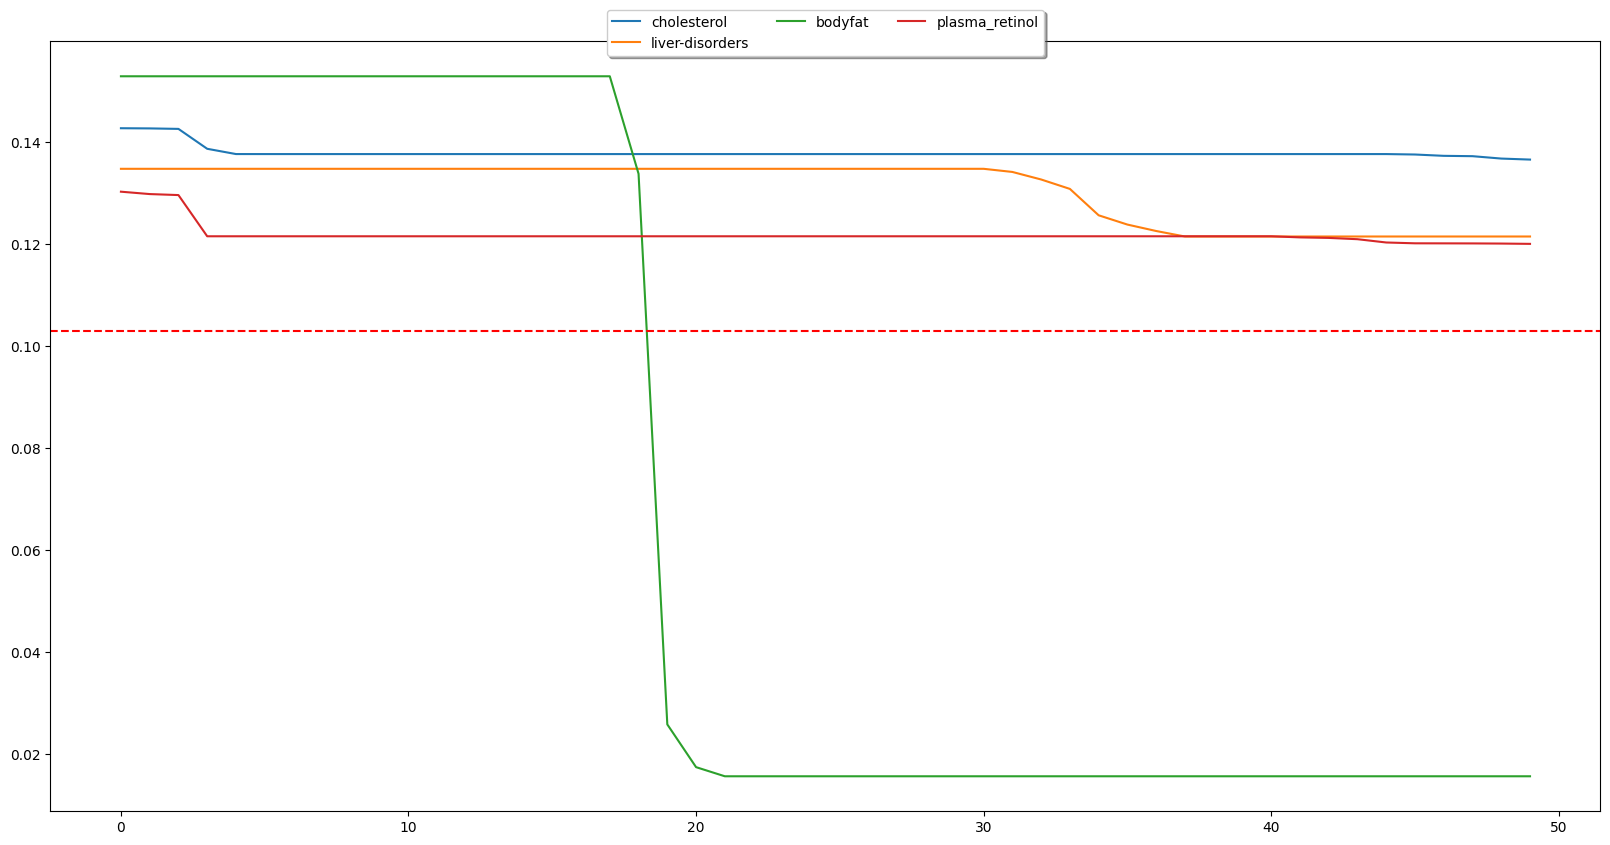

In [114]:
aml_helper.plot_bayes('ElasticNet', dataset_names, bayes_search_results, random_search_best)


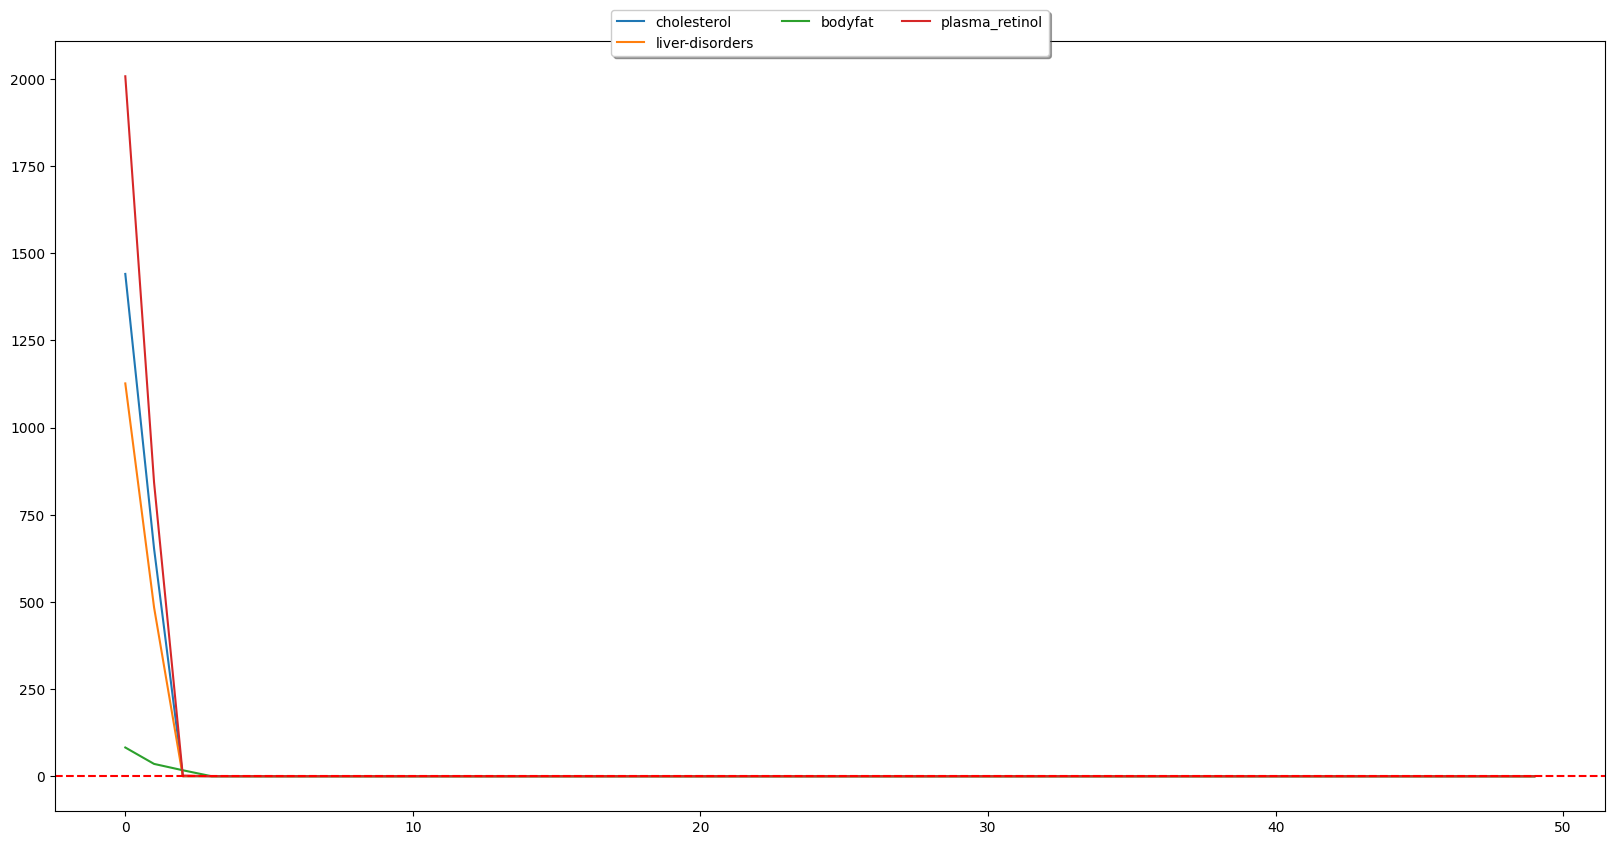

In [113]:
aml_helper.plot_bayes('SVR', dataset_names, bayes_search_results, random_search_best)


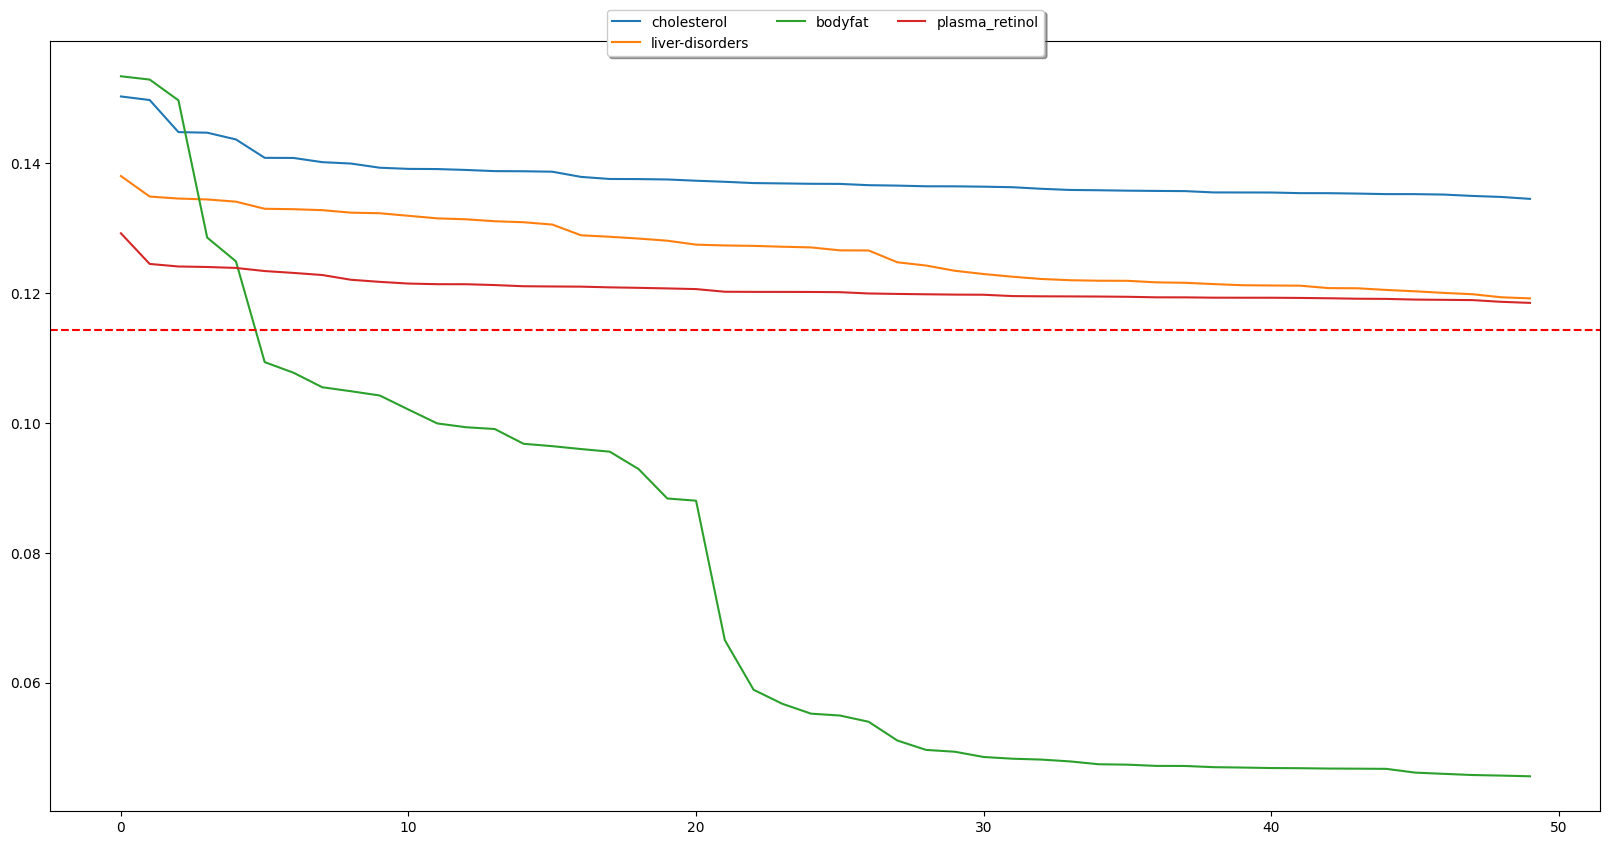

In [112]:
aml_helper.plot_bayes('SGD', dataset_names, bayes_search_results, random_search_best)


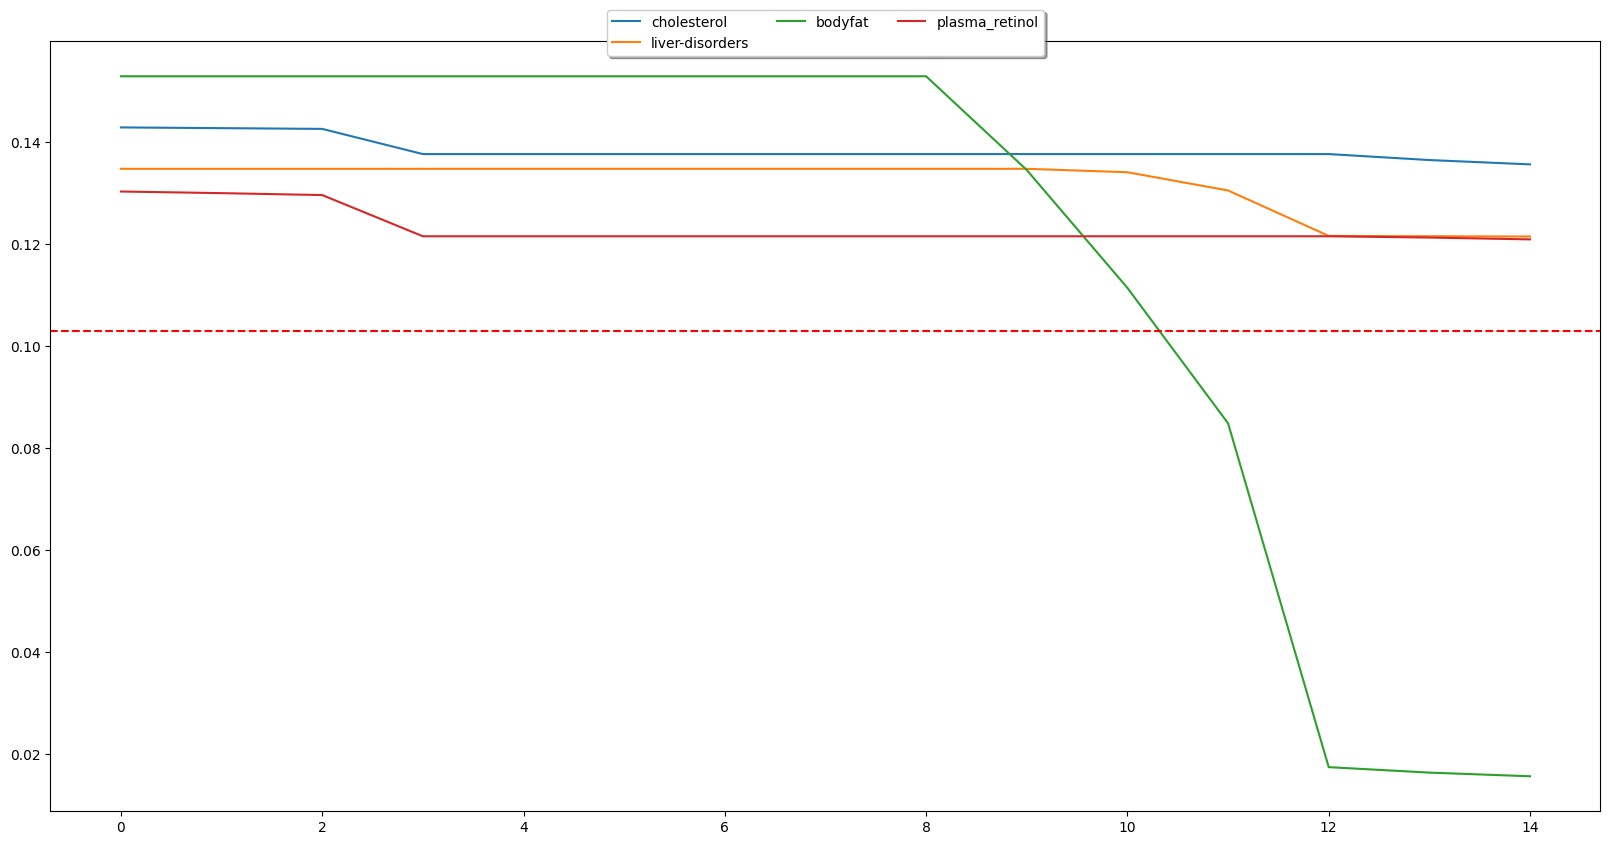

In [115]:
aml_helper.plot_bayes('ElasticNet', dataset_names, grid_search_results, random_search_best)


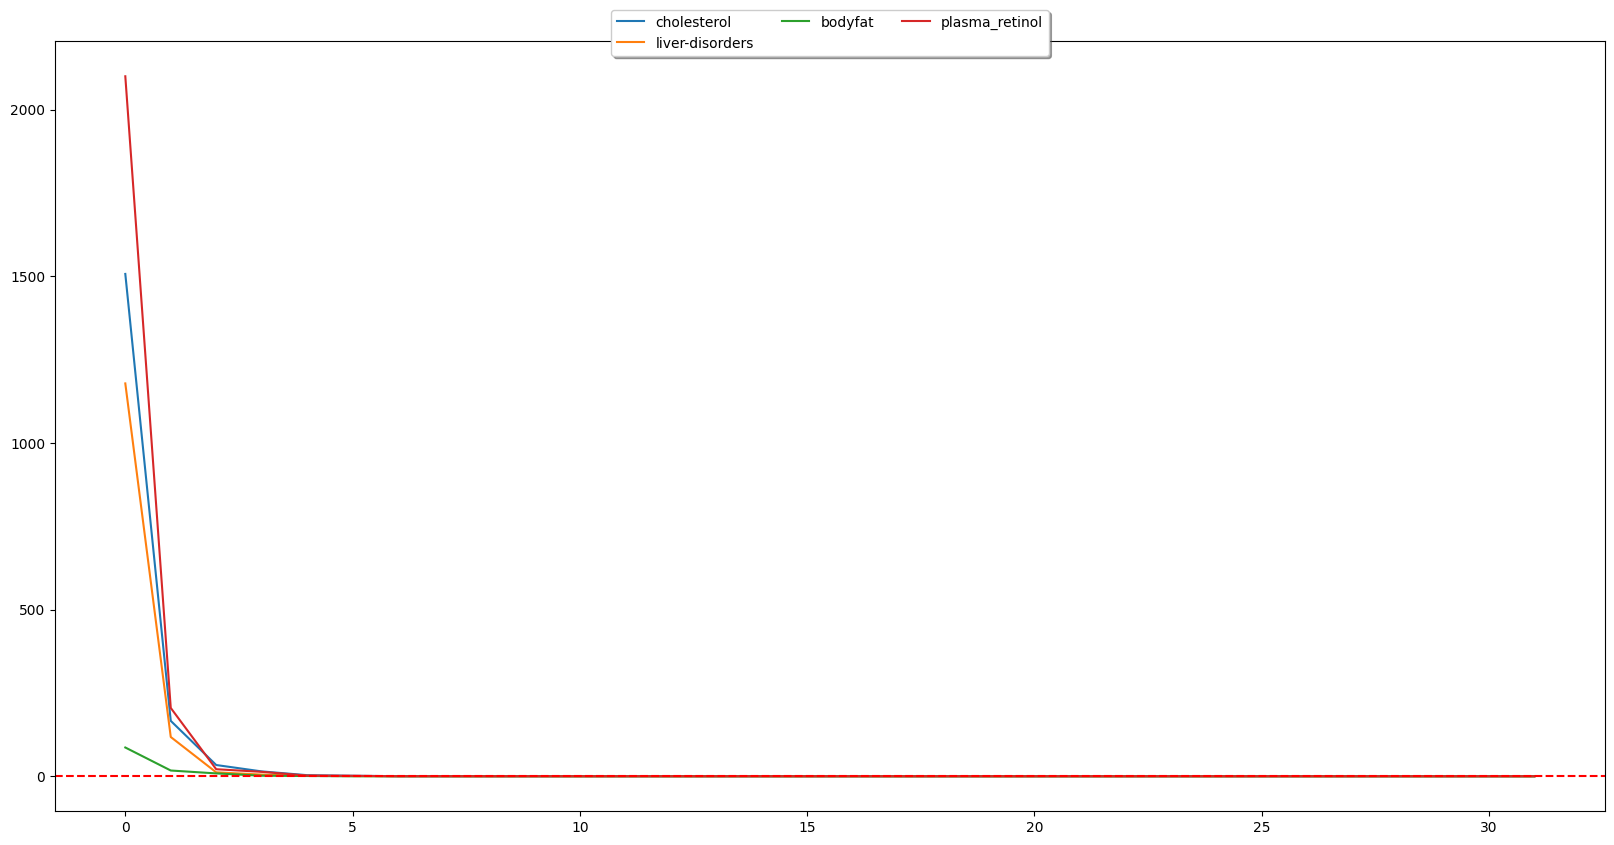

In [116]:
aml_helper.plot_bayes('SVR', dataset_names, grid_search_results, random_search_best)


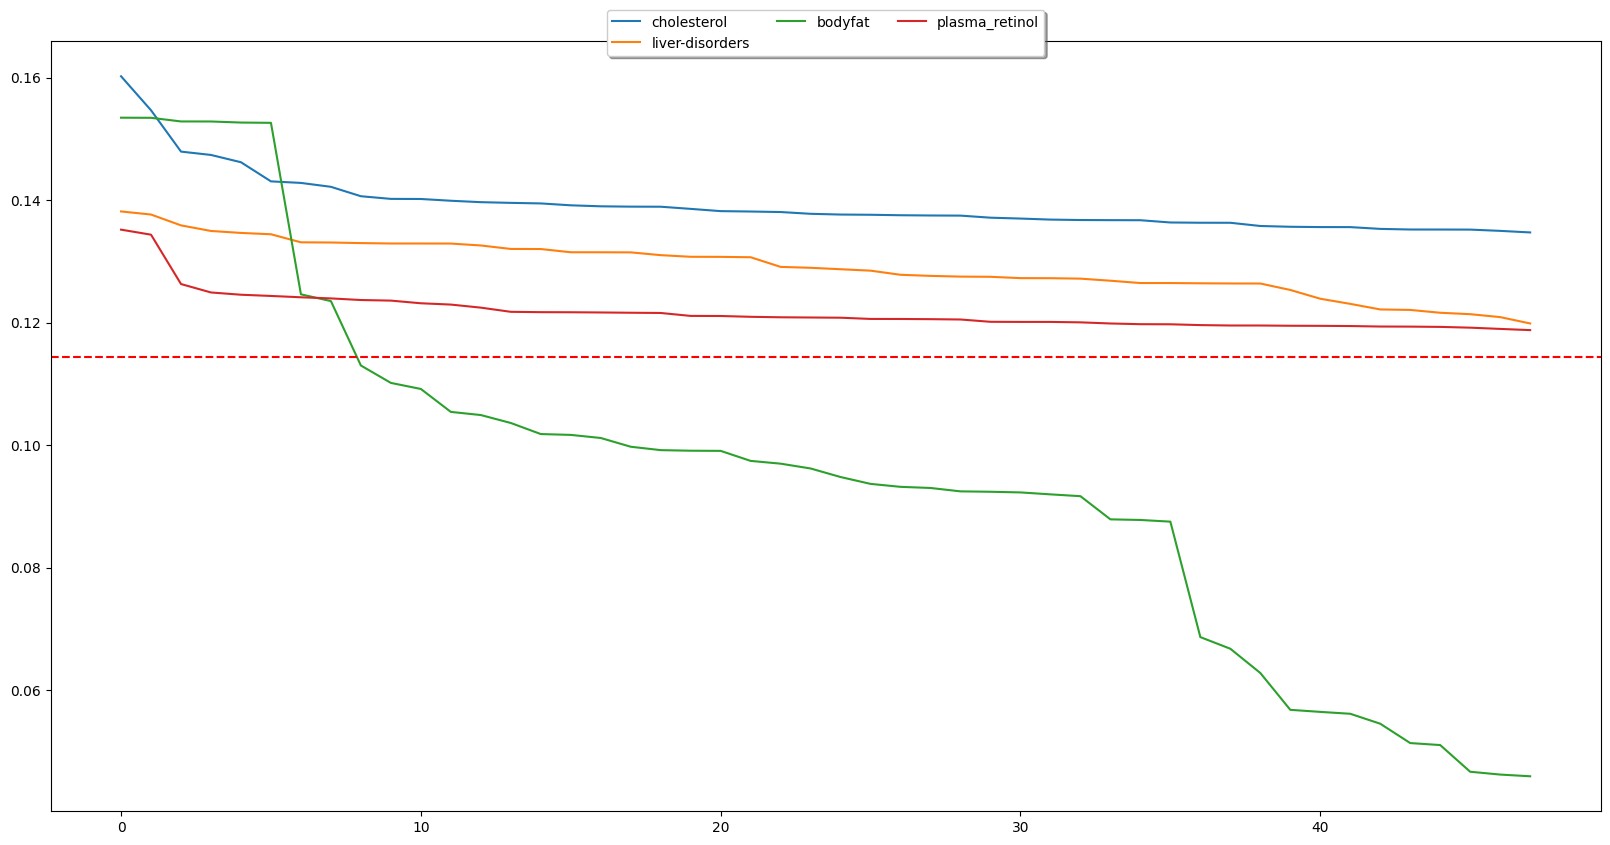

In [117]:
aml_helper.plot_bayes('SGD', dataset_names, grid_search_results, random_search_best)
